In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import zarr  # to read in Zarr format
import gcsfs # to read google cloud data
import momlevel as ml
import cftime
import cmocean
from cartopy import crs as ccrs, feature as cfeature  
import matplotlib.path as mpath

In [2]:
xr.set_options(display_style='html')
%matplotlib inline                           
%config InlineBackend.figure_format='retina' 
plt.rcParams['figure.figsize'] = 12,6  

In [3]:
def North_Polar(array,vmin,vmax,cmap):
    subplot_kws = dict(projection=ccrs.NorthPolarStereo()) 
    fig, ax = plt.subplots(figsize=[10, 5],subplot_kw=subplot_kws)
    
    array.plot(x='geolon', y='geolat',ax=ax,
               transform =ccrs.PlateCarree(),
               vmin=vmin,
               vmax=vmax,
               extend='both',
               cmap=cmap,levels=30)

    # Limit the map to -50 degrees latitude and below.
    ax.set_extent([-180, 180, 50, 90], ccrs.PlateCarree())
    
    # Compute a circle in axes coordinates, which we can use as a boundary
    # for the map. We can pan/zoom as much as we like - the boundary will be
    # permanently circular.
    
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)

    ax.set_boundary(circle, transform=ax.transAxes)
    ax.coastlines()

In [4]:
def South_Polar(array,vmin,vmax,cmap):
    subplot_kws = dict(projection=ccrs.SouthPolarStereo()) 
    fig, ax = plt.subplots(figsize=[10, 5],subplot_kw=subplot_kws)
    
    array.plot(x='geolon', y='geolat',ax=ax,
               transform =ccrs.PlateCarree(),
               vmin=vmin,
               vmax=vmax,
               extend='both',
               cmap=cmap, levels=30)

    # Limit the map to -50 degrees latitude and below.
    ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())
    
    # Compute a circle in axes coordinates, which we can use as a boundary
    # for the map. We can pan/zoom as much as we like - the boundary will be
    # permanently circular.
    
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)

    ax.set_boundary(circle, transform=ax.transAxes)
    ax.coastlines()

### The code in the cell below reads in climate model results stored in the Google Cloud from the GFDL-ESM4 Earth System Model developed at NOAA's Geophysical Fluid Dynamics Laboratory (GFDL). The results are monthly sea surface temperature from the high-emissions future scenario, SSP5-85. A grid cell area file is also loaded in.

In [5]:
df = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')

In [6]:
gfdl_esm4_sst_data = df.query(
    "activity_id=='ScenarioMIP' & \
    table_id == 'Omon' & \
    variable_id == 'tos' & \
    experiment_id == 'ssp585' & \
    institution_id == 'NOAA-GFDL' &  \
    source_id == 'GFDL-ESM4' & \
    grid_label == 'gn' & \
    member_id == 'r1i1p1f1'"
)

# this only needs to be created once
gcs = gcsfs.GCSFileSystem(token='anon')
# get the path to a specific zarr store (the first one from the dataframe above)
zstore_sst = gfdl_esm4_sst_data.zstore.values[-1]
# create a mutable-mapping-style interface to the store
mapper_sst = gcs.get_mapper(zstore_sst)
# open the dataset using xarray and zarr
gfdl_esm4_historical_sst = xr.open_zarr(mapper_sst, 
                                         consolidated=True,use_cftime=True
                                         ).tos.rename({'y':'latitude',
                                                             'x':'longitude',
                                                             'lat':'geolat',
                                                             'lon':'geolon'})
gfdl_esm4_historical_sst

<xarray.DataArray 'tos' (time: 1032, latitude: 576, longitude: 720)>
dask.array<open_dataset-tos, shape=(1032, 576, 720), dtype=float32, chunksize=(64, 576, 720), chunktype=numpy.ndarray>
Coordinates:
    geolat     (latitude, longitude) float32 dask.array<chunksize=(576, 720), meta=np.ndarray>
    geolon     (latitude, longitude) float32 dask.array<chunksize=(576, 720), meta=np.ndarray>
  * time       (time) object 2015-01-16 12:00:00 ... 2100-12-16 12:00:00
  * longitude  (longitude) float64 -299.8 -299.2 -298.8 ... 58.75 59.25 59.75
  * latitude   (latitude) float64 -77.91 -77.72 -77.54 ... 89.47 89.68 89.89
Attributes:
    cell_measures:  area: areacello
    cell_methods:   area: mean where sea time: mean
    long_name:      Sea Surface Temperature
    original_name:  tos
    standard_name:  sea_surface_temperature
    units:          degC

In [7]:
gfdl_esm4_cell_area_data = df.query(
    "activity_id=='CMIP' & \
    table_id == 'Ofx' & \
    variable_id == 'areacello' & \
    experiment_id == 'piControl' & \
    institution_id == 'NOAA-GFDL' &  \
    source_id == 'GFDL-ESM4' & \
    grid_label == 'gn'")

# get the path to a specific zarr store (the first one from the dataframe above)
zstore_area = gfdl_esm4_cell_area_data.zstore.values[-1]
# create a mutable-mapping-style interface to the store
mapper_area = gcs.get_mapper(zstore_area)
# open the dataset using xarray and zarr
gfdl_esm4_cell_area = xr.open_zarr(mapper_area, 
                                         consolidated=True,
                                         ).areacello.rename({'y':'latitude',
                                                             'x':'longitude',
                                                             'lat':'geolat',
                                                             'lon':'geolon'})
gfdl_esm4_cell_area

<xarray.DataArray 'areacello' (latitude: 576, longitude: 720)>
dask.array<open_dataset-areacello, shape=(576, 720), dtype=float32, chunksize=(576, 720), chunktype=numpy.ndarray>
Coordinates:
    geolat     (latitude, longitude) float32 dask.array<chunksize=(576, 720), meta=np.ndarray>
    geolon     (latitude, longitude) float32 dask.array<chunksize=(576, 720), meta=np.ndarray>
  * longitude  (longitude) float64 -299.8 -299.2 -298.8 ... 58.75 59.25 59.75
  * latitude   (latitude) float64 -77.91 -77.72 -77.54 ... 89.47 89.68 89.89
Attributes:
    cell_methods:   area: sum
    long_name:      Grid-Cell Area
    original_name:  areacello
    standard_name:  cell_area
    units:          m2

### In the cells below, produce an analysis that assesses and quantifies the change in area-weighted global average SST, arctic SST, antarctic SSTs. Your analysis must consider different timescales (monthly, annual, seasonal etc). You must include figures in your analysis and a description of the spatial patterns you observe.

### Your spatial plots should utilize `geolon` and `geolat` to remove the distortion in the polar regions .... https://mom6-analysiscookbook.readthedocs.io/en/latest/notebooks/Plotting.html

In [8]:
monthly_SST=gfdl_esm4_historical_sst

In [9]:
annual_SST= ml.util.annual_average(monthly_SST,tcoord='time')

In [10]:
global_weighted_avg_SST= monthly_SST.weighted(gfdl_esm4_cell_area).mean(['latitude', 'longitude'])

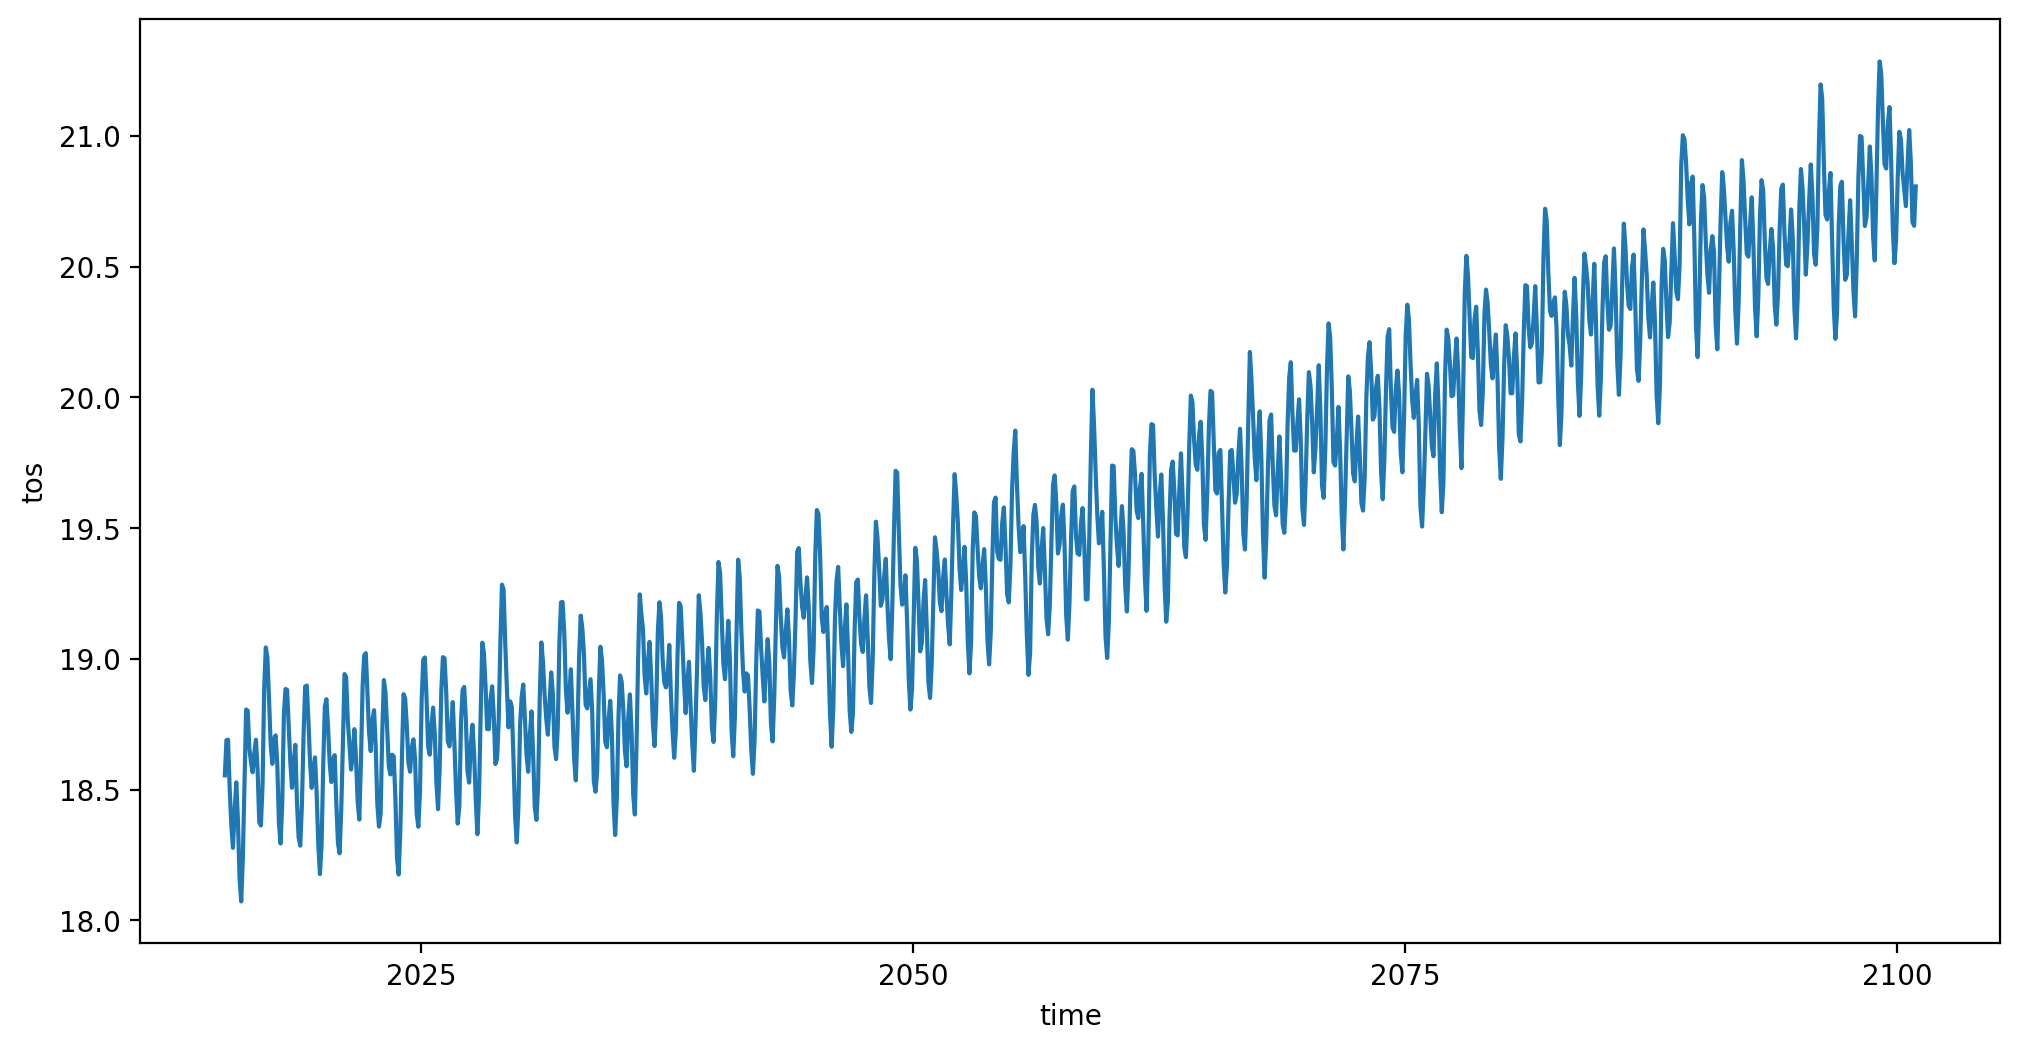

In [11]:
#global monthly sst over time
global_weighted_avg_SST.plot()

In [12]:
arctic=monthly_SST.sel(latitude=slice(-90,0))
antarctic=monthly_SST.sel(latitude=slice(0,90))

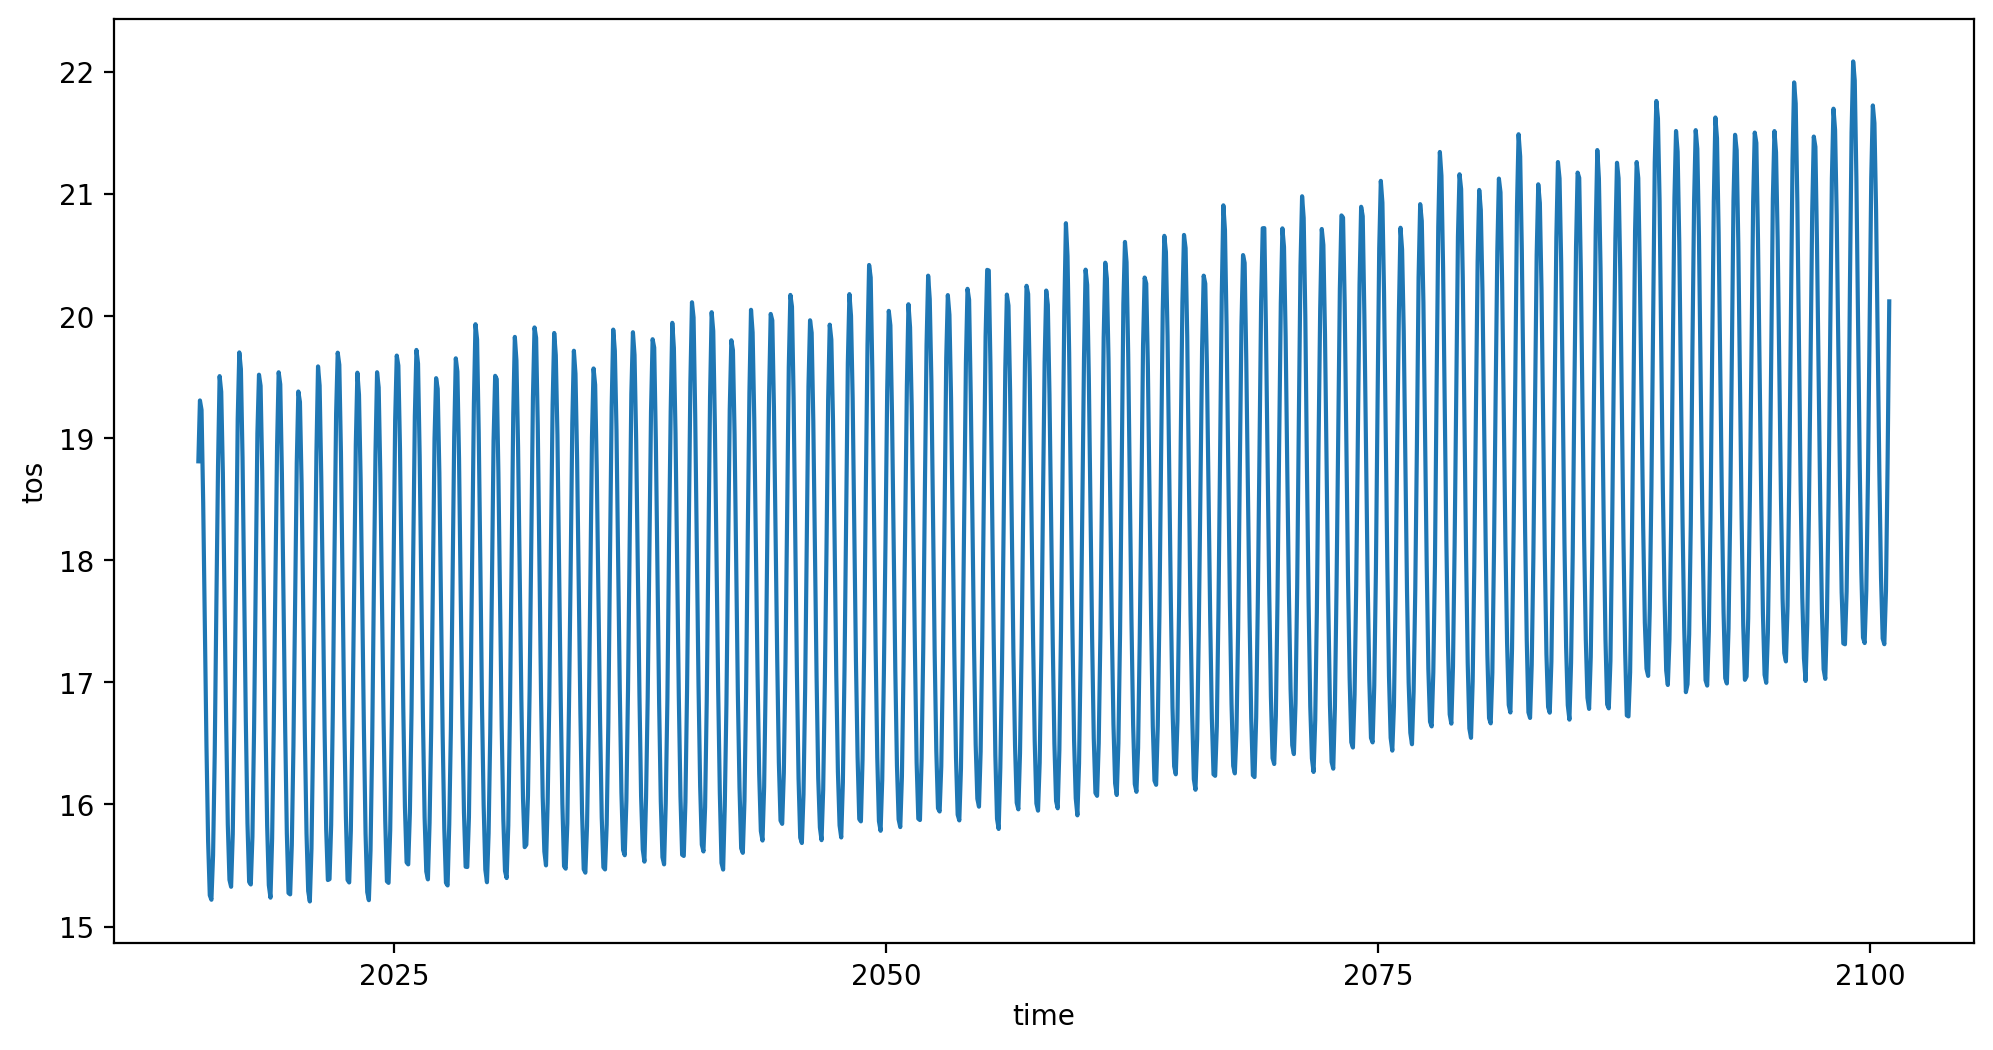

In [13]:
#monthly arctic SST over time
arctic_weighted_avg_SST= arctic.weighted(gfdl_esm4_cell_area).mean(['latitude', 'longitude'])
arctic_weighted_avg_SST.plot()

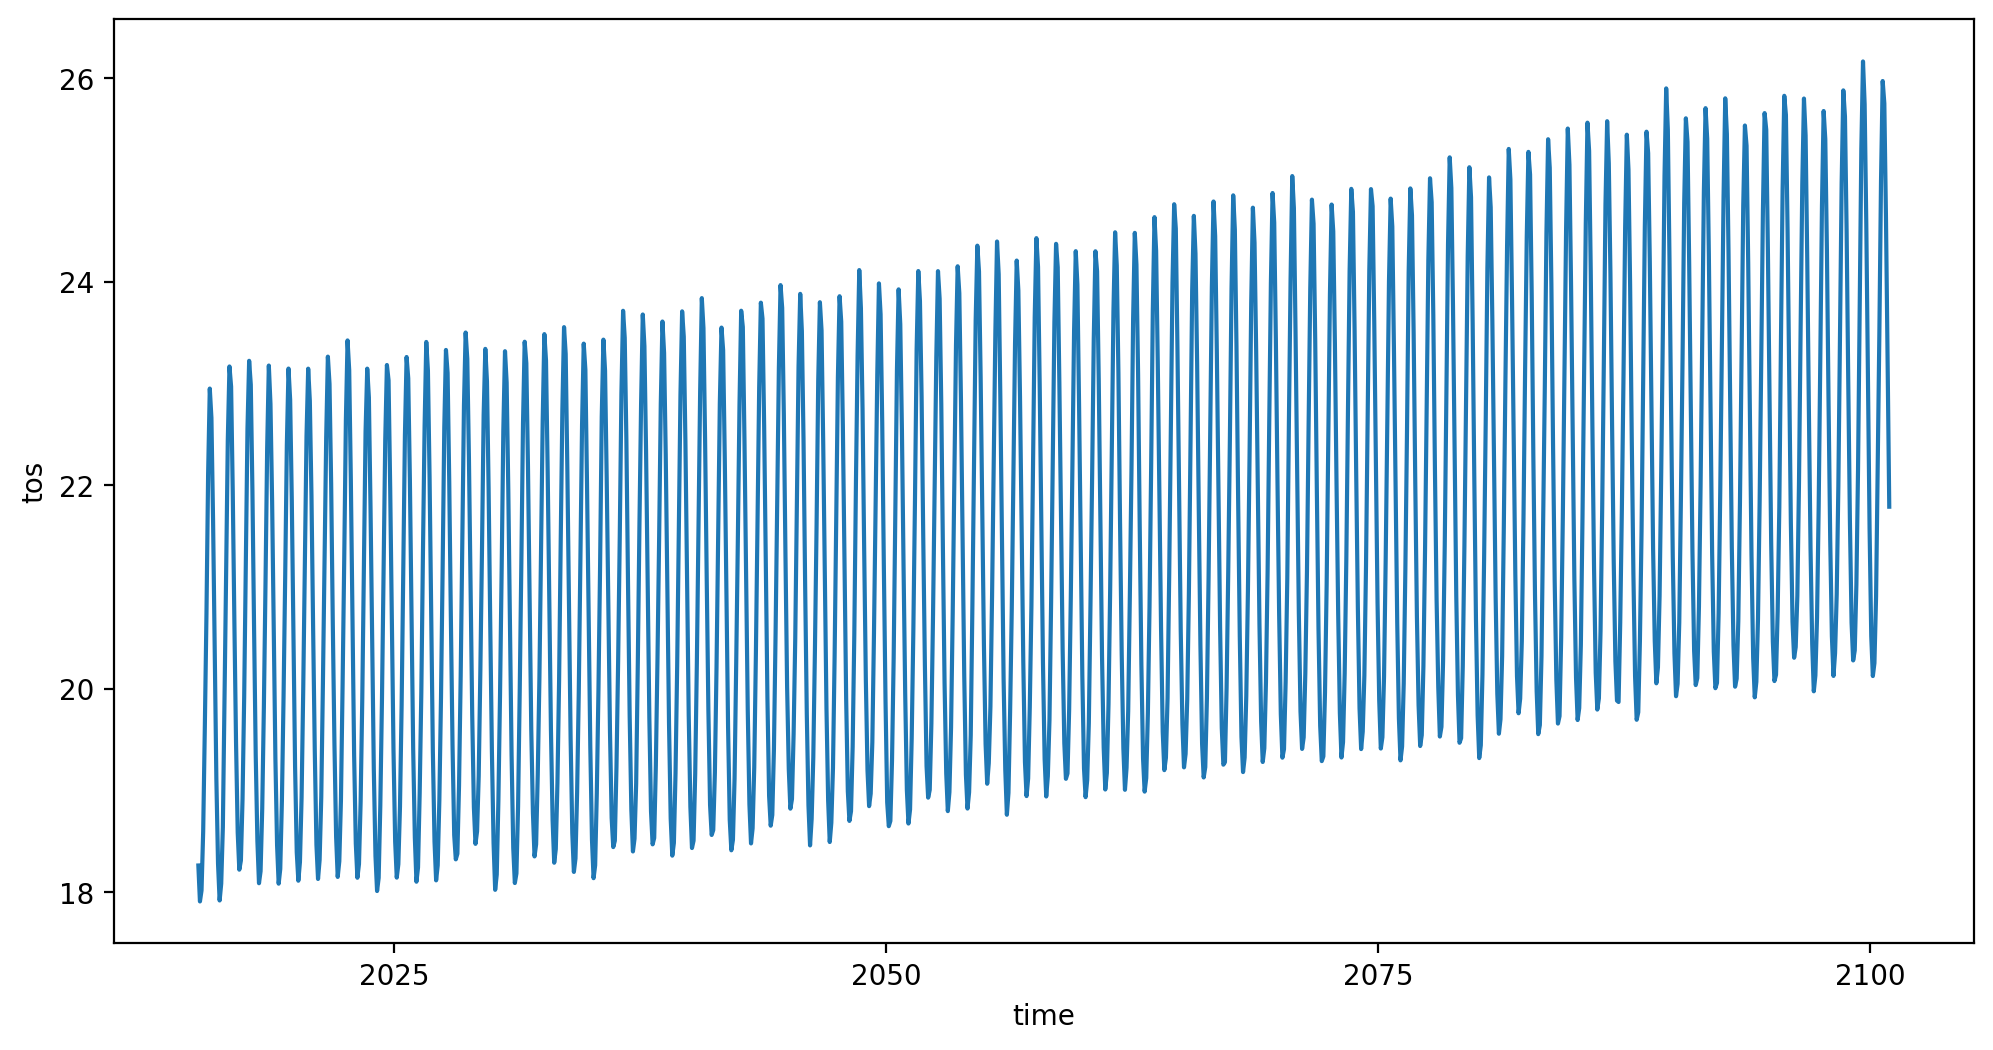

In [14]:
#monthly antactic SST over time
antarctic_weighted_avg_SST= antarctic.weighted(gfdl_esm4_cell_area).mean(['latitude', 'longitude'])
antarctic_weighted_avg_SST.plot()

In [23]:
monthgroup_SST=monthly_SST.groupby('time.month').mean(dim='time')
monthly_average=monthgroup_SST.weighted(gfdl_esm4_cell_area).mean(['latitude', 'longitude'])

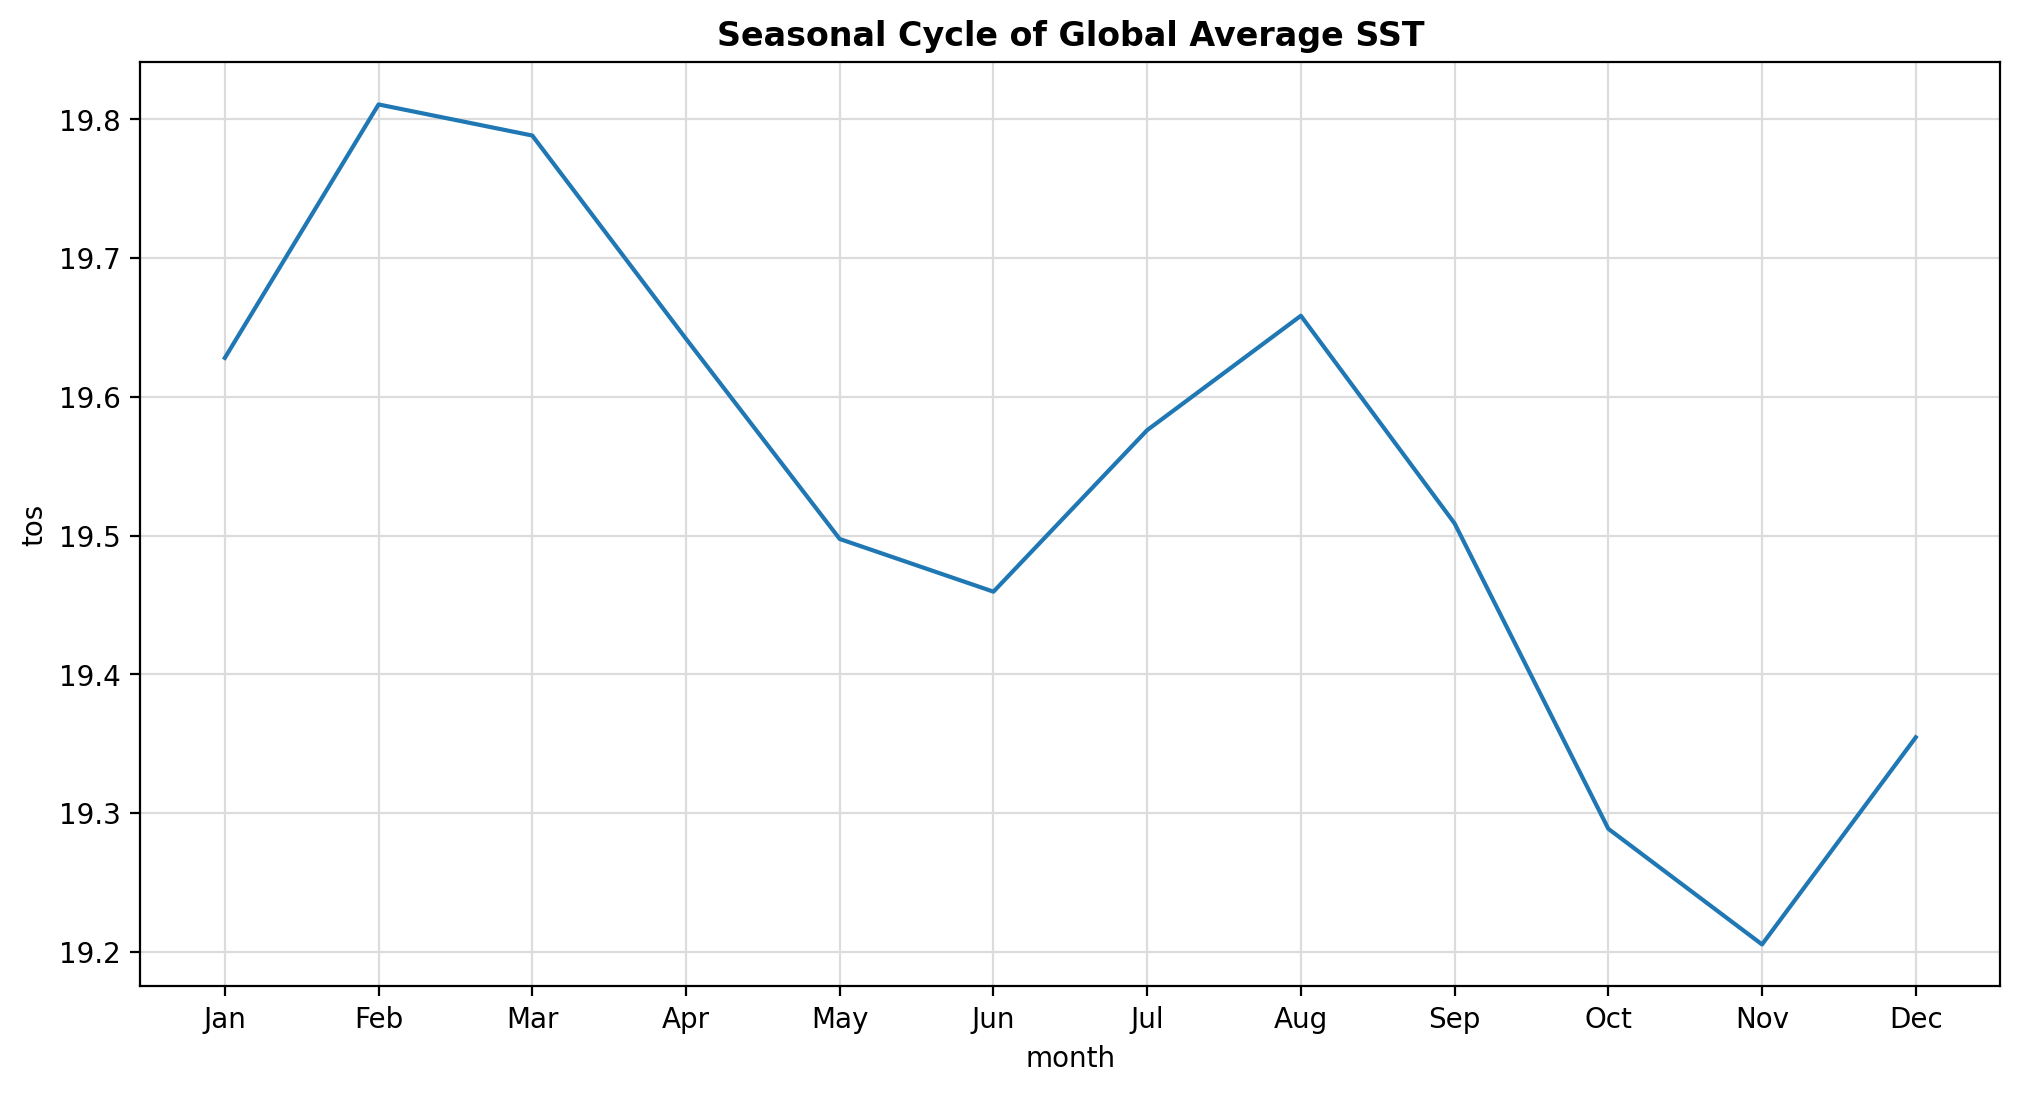

In [30]:
monthly_average.plot()
plt.xticks([1, 2, 3, 4, 5, 6, 7,  8, 9, 10, 11, 12],
              ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
plt.title("Seasonal Cycle of Global Average SST", fontweight='bold')
plt.grid(color='gainsboro')

In [16]:
first10=annual_SST.sel(time=slice('2015-07-02', '2025-07-02')).mean(dim='time')
last10=annual_SST.sel(time=slice('2090-07-02', '2100-07-02')).mean(dim='time')

difference=last10-first10

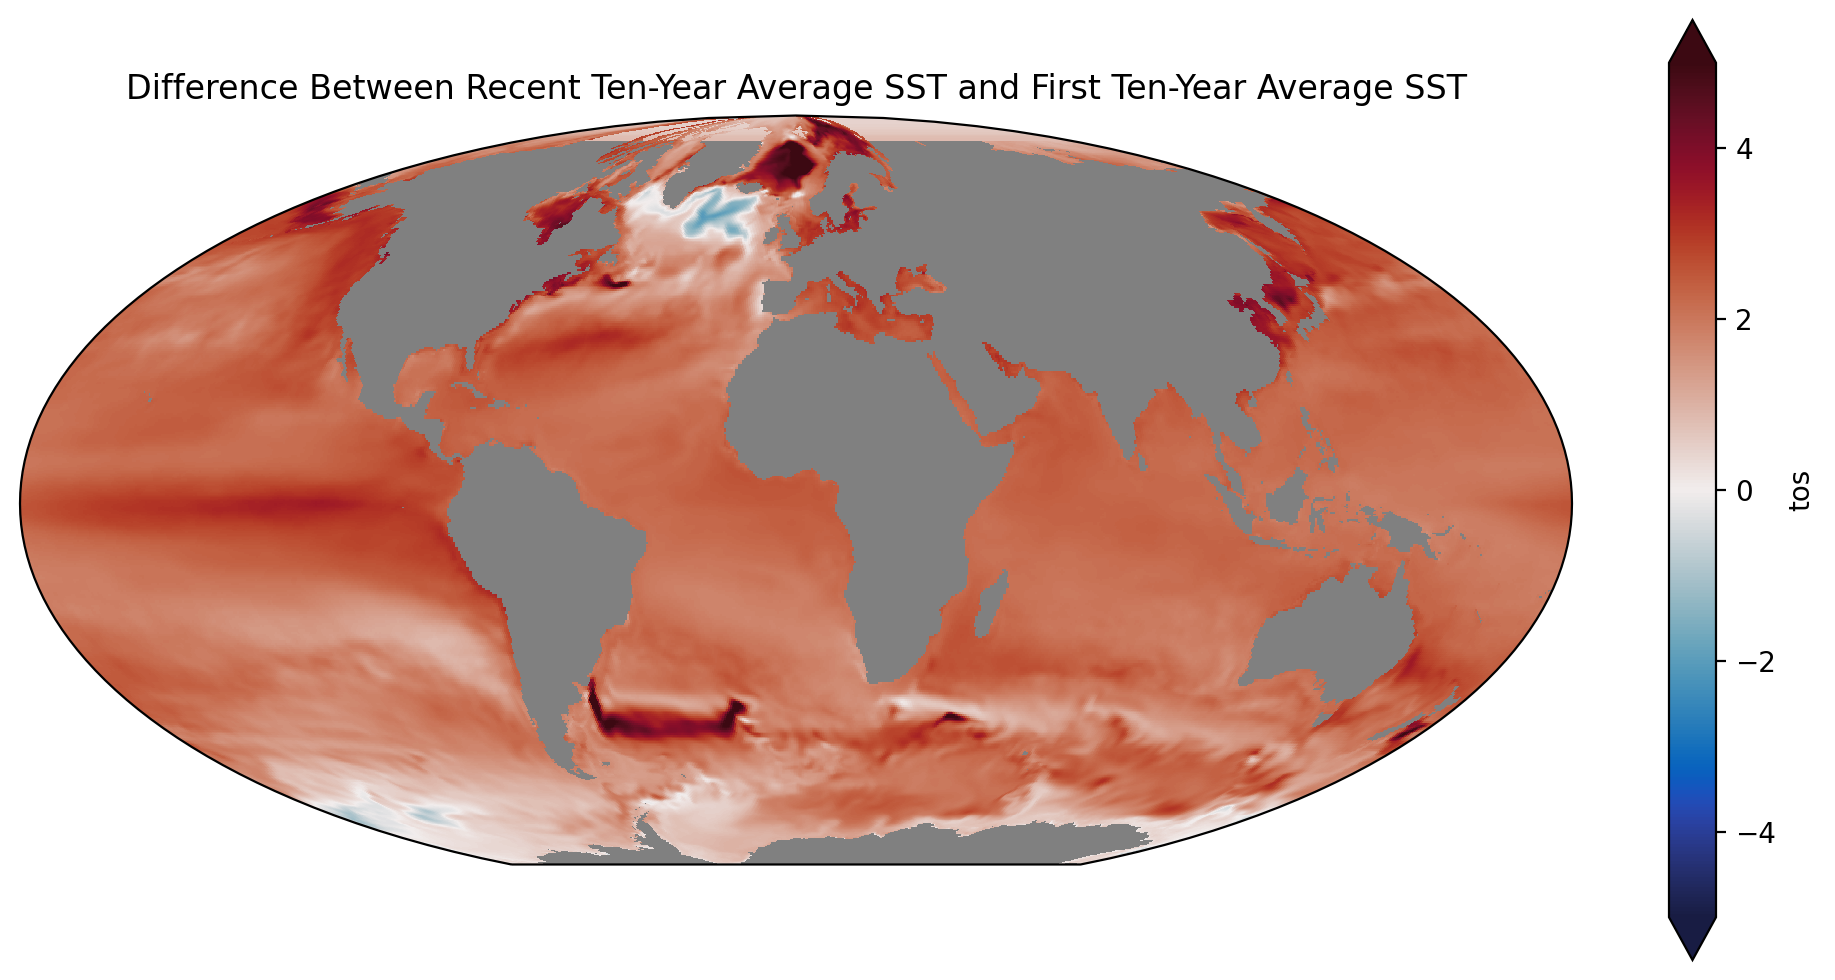

In [17]:
subplot_kws=dict(projection=ccrs.Mollweide(),
                 facecolor='grey')

fig, (ax)=plt.subplots(ncols=1,nrows=1, figsize=(10,5),subplot_kw=subplot_kws)
difference.plot(ax=ax, cmap=cmocean.cm.balance, vmin=-5,vmax=5, 
                extend='both',transform=ccrs.PlateCarree())

ax.set_title('Difference Between Recent Ten-Year Average SST and First Ten-Year Average SST')
plt.tight_layout()

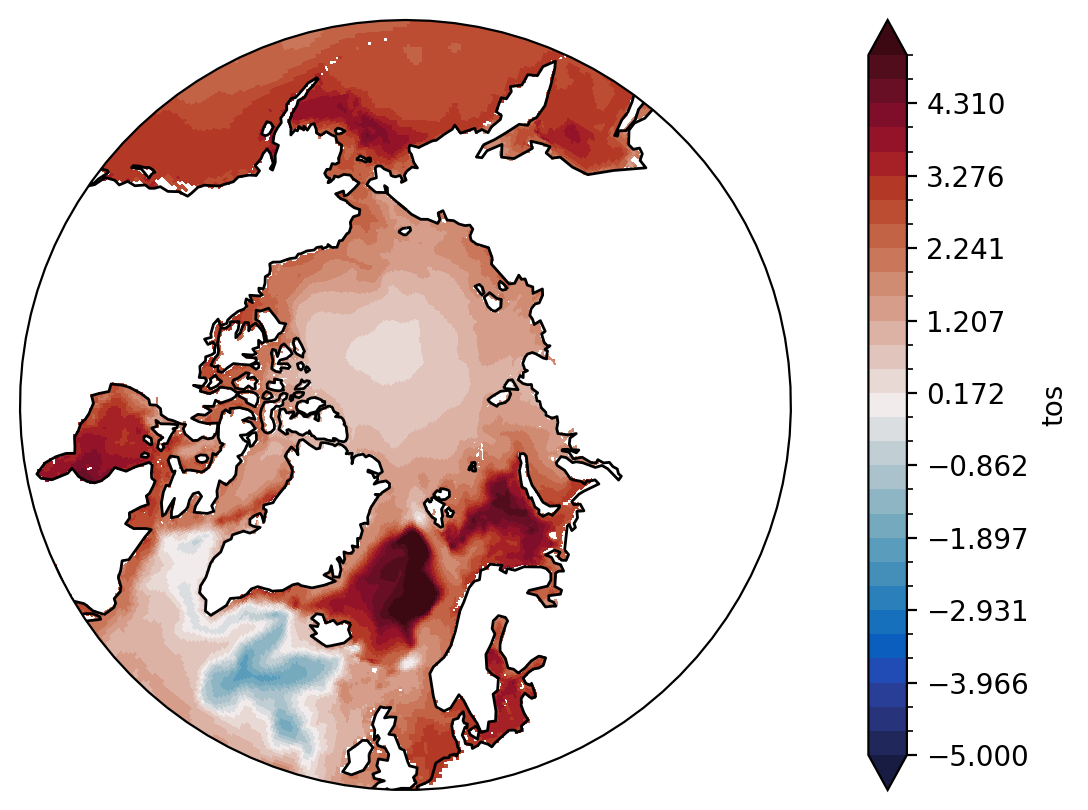

In [18]:
North_Polar(difference, -5, 5, cmocean.cm.balance)

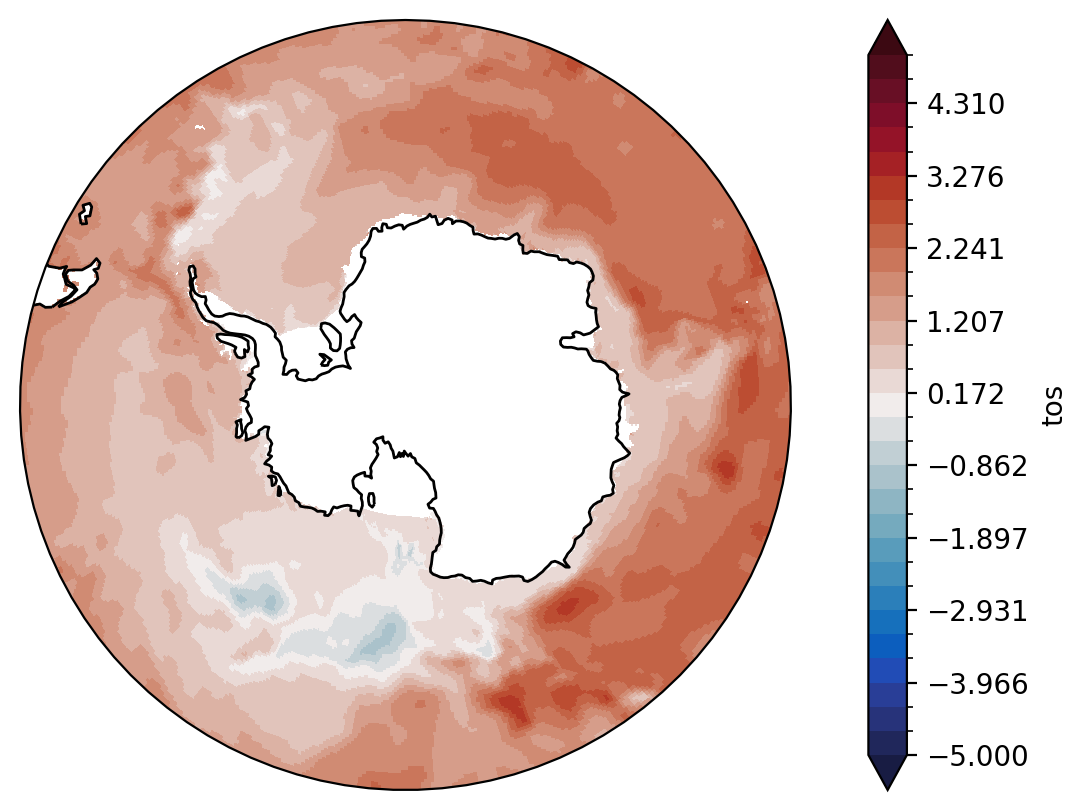

In [19]:
South_Polar(difference, -5, 5, cmocean.cm.balance)